In [1]:
import sys
sys.path.append("..")
from VAE.vae import *

In [2]:
data_dir  = os.path.normpath(os.path.join(os.getcwd(), "../../runs/FIA/Sampled_Coms"))
data = read_data(data_dir, verbosity=0)
X = np.random.uniform(0.0, 1.0, size=(5, 825000))

In [3]:
config_space = ConfigurationSpace(
                {'input_dropout': 0.1, 'intermediate_activation': "relu", 'intermediate_dimension': 30,
                'intermediate_layers': 1, 'latent_dimension': 3, 'learning_rate': 1e-6,
                'original_dim': 825000, 'solver': 'nadam', "tied": 1, "kld_weight": 0.1, "stdev_noise": 1e-12,
                "reconstruction_loss_function": "spectral_entropy"}
            )
config = config_space.get_default_configuration()

In [4]:
model = FIA_VAE(config)

In [5]:
model.summary()

Model: "fia_vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_intermediate            │ ?                      │    24,750,123 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_mu (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_sigma (Dense)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_reparametrization        │ ?                      │   0 (unbuilt) │
│ (Sampling)                      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder (Sequential)            │ ?                      │    25,575,153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,575,153 (97.56 MB)

 Trainable params: 25,575,153 (97.56 MB)

 Non-trainable params: 0 (0.00 B)

In [107]:
@keras.saving.register_keras_serializable(package="FIA_VAE")
def spectral_entropy(spectrum):
    spectrum = ops.normalize(spectrum, order=1) # Total count normalization
    return -ops.sum( ops.multiply( spectrum, ops.log( ops.add(spectrum, 1e-32) ) ), axis=-1 )

@keras.saving.register_keras_serializable(package="FIA_VAE")
def spectral_entropy_divergence(y_true, y_pred):
    y_comb = ops.add(y_true, y_pred)
    return ops.mean( ops.abs(                     # floating point errors can lead to small negative values
                ops.divide(
                    ops.subtract( ops.multiply(2, spectral_entropy( y_comb ) ) ,
                                  ops.add( spectral_entropy( y_true ), spectral_entropy( y_pred ) ) ),
                    ops.log(4) ) ) )

In [108]:
d1 = np.float32( [[0, 1e-22, 0, 0]] )
d2 = np.float32( [[1, 1, 1, 1]] )
spectral_entropy_divergence(d1, d2).numpy()

1.0

In [102]:
ops.mean(ops.multiply( d1, ops.log( ops.add(d1, 1e-32))), axis=0)

<tf.Tensor: shape=(4,), dtype=float32, numpy=
array([-0.000000e+00, -5.065687e-21, -0.000000e+00, -0.000000e+00],
      dtype=float32)>

In [16]:
d1 =  np.float32(model(data, training=False)[2])
d2 = np.float32(data.iloc[0])
spectral_entropy_divergence(d1, d2).numpy()

0.049513116

In [9]:
model.fit(data, data, validation_split=0.2, batch_size=100, epochs=5, callbacks=[])

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - kl_loss: -0.0000e+00 - loss: 7.5535 - reconstruction_loss: 7.5535

KeyboardInterrupt: 

## Saving

In [ ]:
keras.saving.save_model(model, "../../runs/VAE/training/test/test.keras")

In [ ]:
model.save_weights("../../runs/VAE/training/test/test.weights.h5")

## Loading

In [ ]:
model2 = keras.saving.load_model("../../runs/VAE/training/test/test.keras")

In [ ]:
model2.load_weights("../../runs/VAE/training/test/test.weights.h5")

## Testing

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint( filepath="../../runs/VAE/training/test/test_{epoch}.keras",
                                                  save_best_only=True, monitor="val_loss",
                                                  verbose=1 )

In [ ]:
mlflow.login()
mlflow.set_experiment(f"/Users/josua.carl@student.uni-tuebingen.de/FIA_VAE")
run = mlflow.start_run(run_name="VAE Test", nested=False)
mlflow_cb = mlflow.keras.MlflowCallback(run)

2024/05/13 17:05:42 INFO mlflow.utils.credentials: Successfully connected to MLflow hosted tracking server! Host: https://community.cloud.databricks.com.


In [ ]:
model2.fit(data, data, validation_split=0.2, batch_size=32, epochs=10, callbacks=[])

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 7s/step - kl_loss: -0.0000e+00 - loss: 2.2351 - reconstruction_loss: 2.2351 - val_kl_loss: -0.0000e+00 - val_loss: 0.5356 - val_reconstruction_loss: 0.5356
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 995ms/step - kl_loss: -0.0000e+00 - loss: 2.2202 - reconstruction_loss: 2.2202 - val_kl_loss: -0.0000e+00 - val_loss: 0.5405 - val_reconstruction_loss: 0.5405
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 964ms/step - kl_loss: -0.0000e+00 - loss: 2.1945 - reconstruction_loss: 2.1945 - val_kl_loss: -0.0000e+00 - val_loss: 0.5141 - val_reconstruction_loss: 0.5141
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - kl_loss: -0.0000e+00 - loss: 2.1684 - reconstruction_loss: 2.1684 - val_kl_loss: -0.0000e+00 - val_loss: 0.5036 - val_reconstruction_loss: 0.5036
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 952ms/step - kl_loss: -0.0000e+00 - loss: 2.1586 - reconstruction_loss: 2.1586 - val_kl_loss: 1.1921e-07 - val_loss: 0.4978 - val_reconstruction_loss: 0.4978
Epoch 6/10
3/3 ━

In [ ]:
loss, kl_loss, recon_loss = model2.evaluate(data, data, batch_size=68)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - kl_loss: -0.0000e+00 - loss: 3.2170 - reconstruction_loss: 3.2170


In [ ]:
prediction = pd.DataFrame(model2.predict(data))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [ ]:
plot_df = pd.DataFrame(prediction.loc[1].values, index=data.columns, columns=["inty"]).reset_index()
plot_df_2 = pd.DataFrame(data.iloc[1].values, index=data.columns, columns=["inty"]).reset_index()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

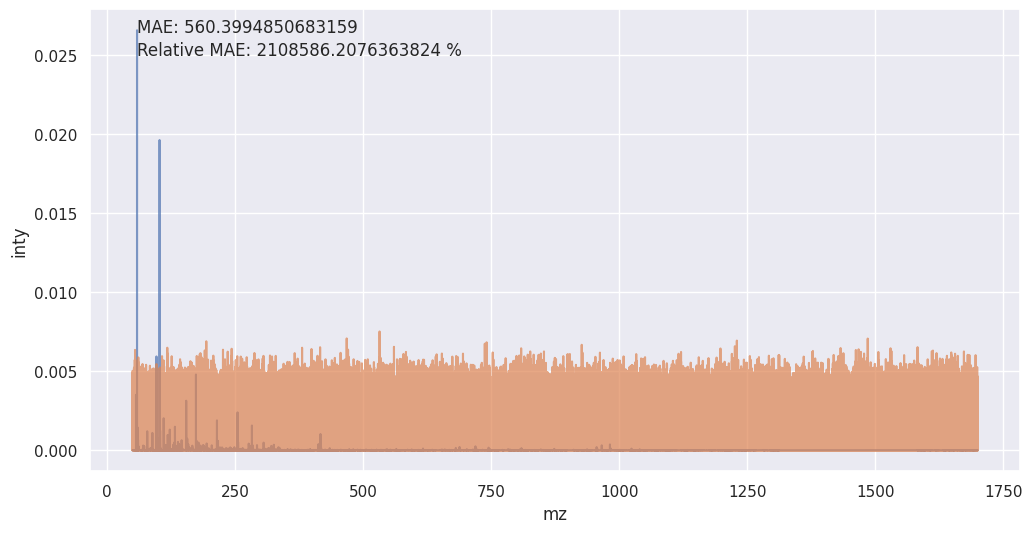

In [ ]:
mae = np.mean(np.sum( np.abs((plot_df_2["inty"] - plot_df["inty"])) ))
rel_mae = mae / np.max(plot_df_2["inty"])

sns.set_theme(rc={"figure.figsize":(12, 6)})
ax = sns.lineplot(data=plot_df_2, x="mz", y="inty", alpha=0.7)
ax = sns.lineplot(data=plot_df, x="mz", y="inty", alpha=0.7)
plt.annotate(f"MAE: {mae}", xy=(0.05, 0.95), xycoords='axes fraction')
plt.annotate(f"Relative MAE: {rel_mae *100} %", xy=(0.05, 0.90), xycoords='axes fraction')
plt.show()